# Toxicity - Argument Quality Timeseries Analysis

In [1]:
%load_ext autoreload
%autoreload 2

import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import scipy.stats

import tasks.stats
import tasks.postprocessing
import tasks.graphs

In [2]:
tqdm.tqdm.pandas()
sns.set(style="whitegrid")

In [3]:
from tasks.constants import *


TOXICITY_TICKS = np.arange(1, 6, 1)
YTICKS_LIST = [TOXICITY_TICKS, TOXICITY_TICKS]
VMIN_TOXICITY = -1
VMAX_TOXICITY = 1

## Preprocessing

In [4]:
full_df = tasks.postprocessing.get_main_dataset()
full_df

,conv_id,message_id,message_order,conv_variant,model,user,user_prompt,is_moderator,intent,message,Toxicity,Argument Quality,not_intervened
0,75173c9d-9d25-4389-93d9-6fd7978e30b8,553054330741756452,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",2,4,False
1,75173c9d-9d25-4389-93d9-6fd7978e30b8,553054330741756452,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",4,5,False
2,75173c9d-9d25-4389-93d9-6fd7978e30b8,553054330741756452,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",3,4,False
3,75173c9d-9d25-4389-93d9-6fd7978e30b8,553054330741756452,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",3,4,False
4,75173c9d-9d25-4389-93d9-6fd7978e30b8,553054330741756452,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",4,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51310,8e301e72-344d-4331-89bc-4dc1edca20fe,1737594611854314181,21,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False
51311,8e301e72-344d-4331-89bc-4dc1edca20fe,1737594611854314181,21,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False
51312,8e301e72-344d-4331-89bc-4dc1edca20fe,1737594611854314181,21,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False
51313,8e301e72-344d-4331-89bc-4dc1edca20fe,1737594611854314181,21,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False


In [5]:
no_hardocoded_df = full_df[full_df.model != "hardcoded"]

In [6]:
no_mod_df = no_hardocoded_df.copy()
no_mod_df = no_mod_df[~no_mod_df.is_moderator]
contains_mod = no_mod_df.conv_variant != "No Moderator"
no_mod_df.loc[contains_mod, "message_order"] = (
    no_mod_df[contains_mod].message_order // 2 + 1
)

## Timeseries analysis

### Role

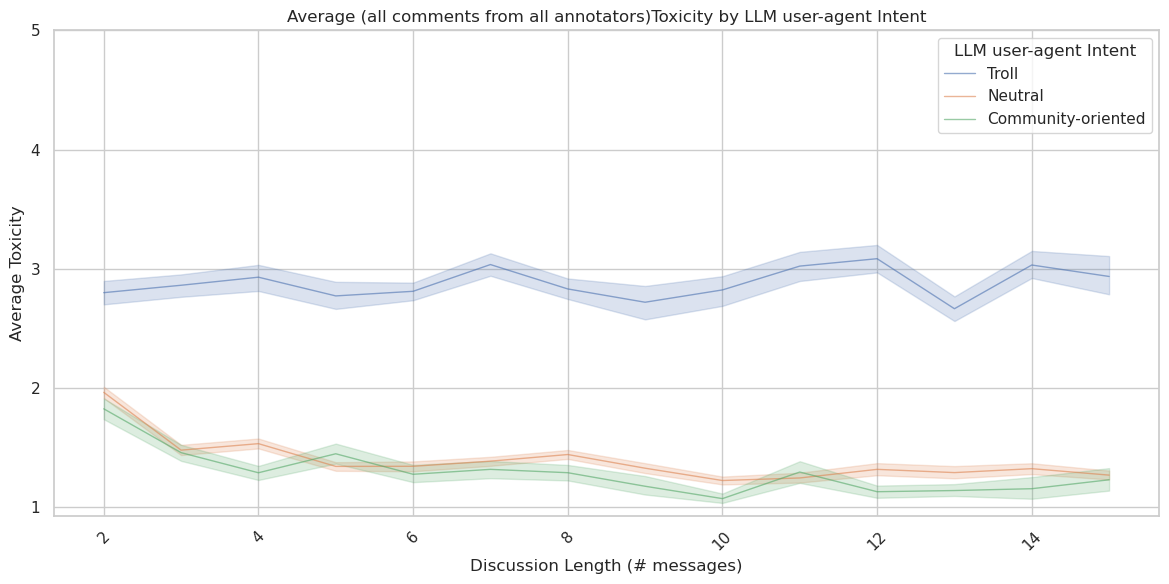

In [7]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Toxicity",
    hue_col="intent",
    hue_col_label="LLM user-agent Intent",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

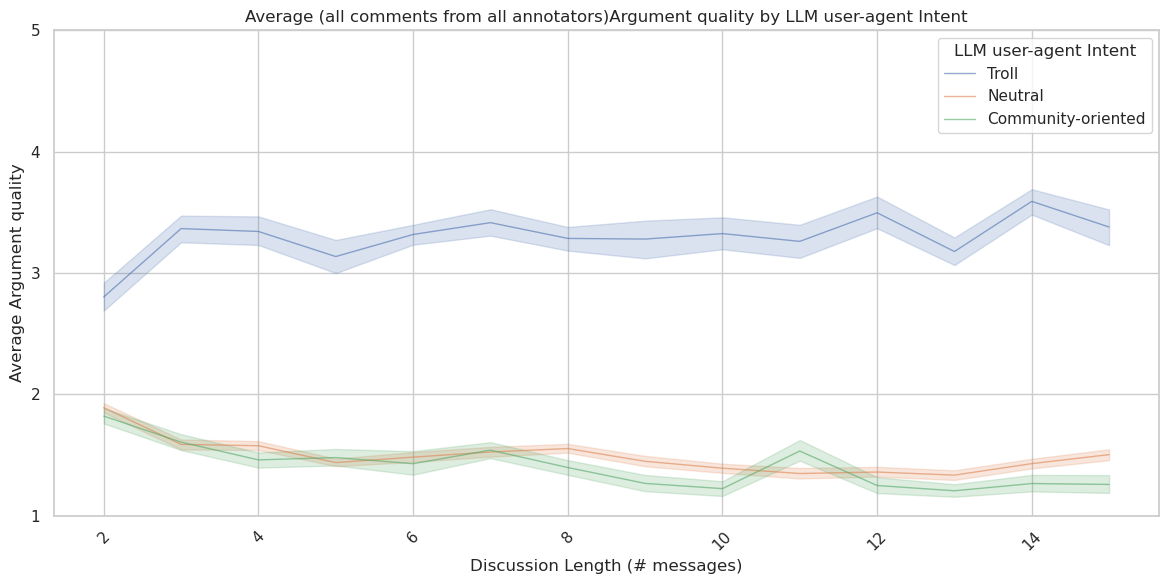

In [8]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Argument Quality",
    hue_col="intent",
    hue_col_label="LLM user-agent Intent",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

### Moderation Strategy

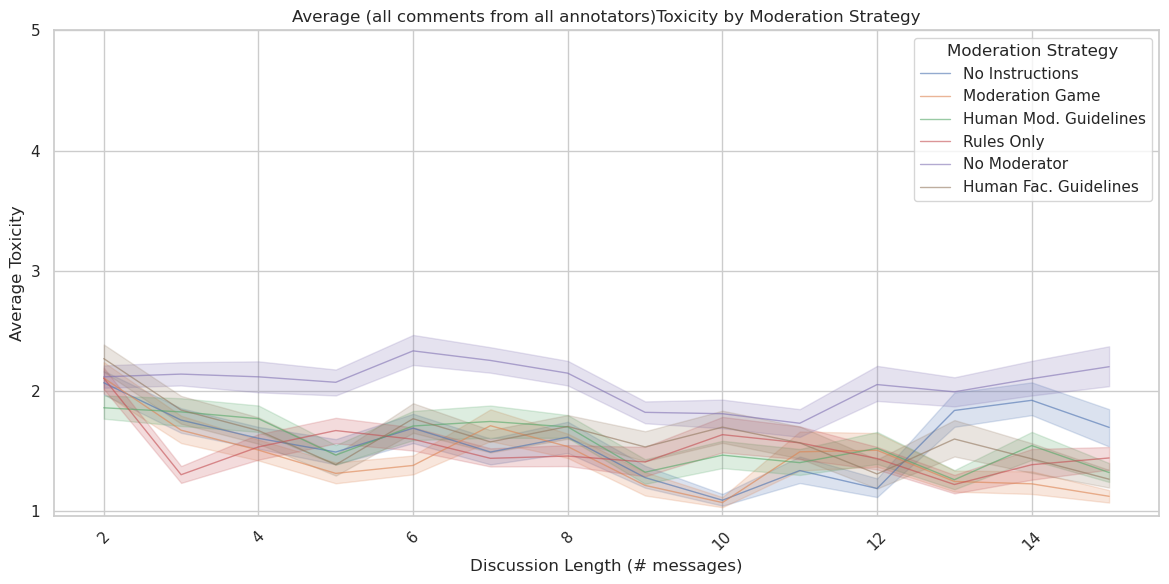

In [9]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Toxicity",
    hue_col="conv_variant",
    hue_col_label="Moderation Strategy",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

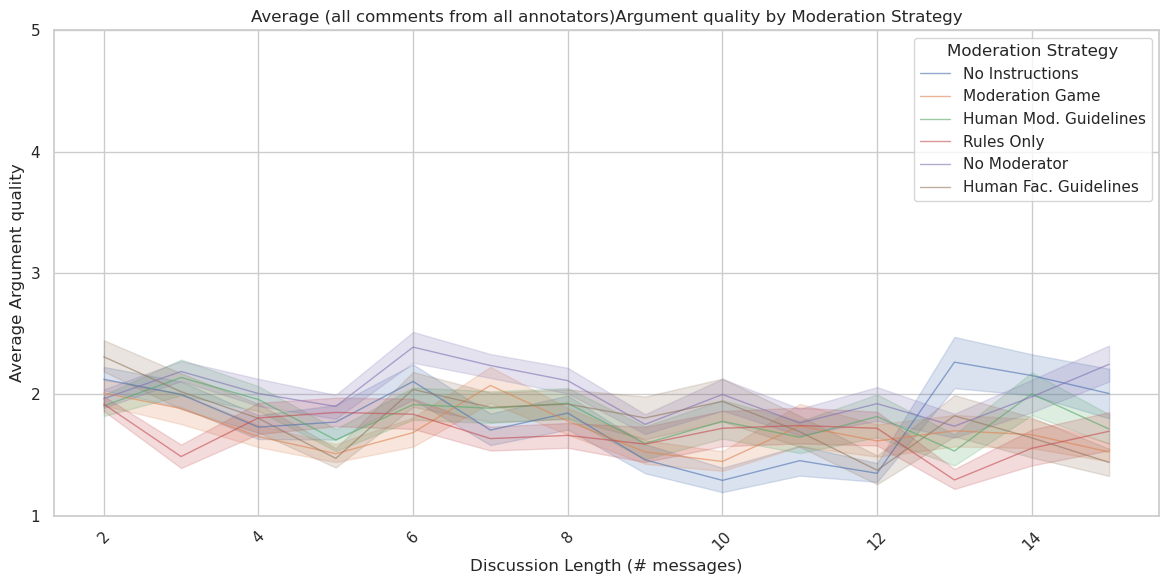

In [10]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Argument Quality",
    hue_col="conv_variant",
    hue_col_label="Moderation Strategy",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

### Models

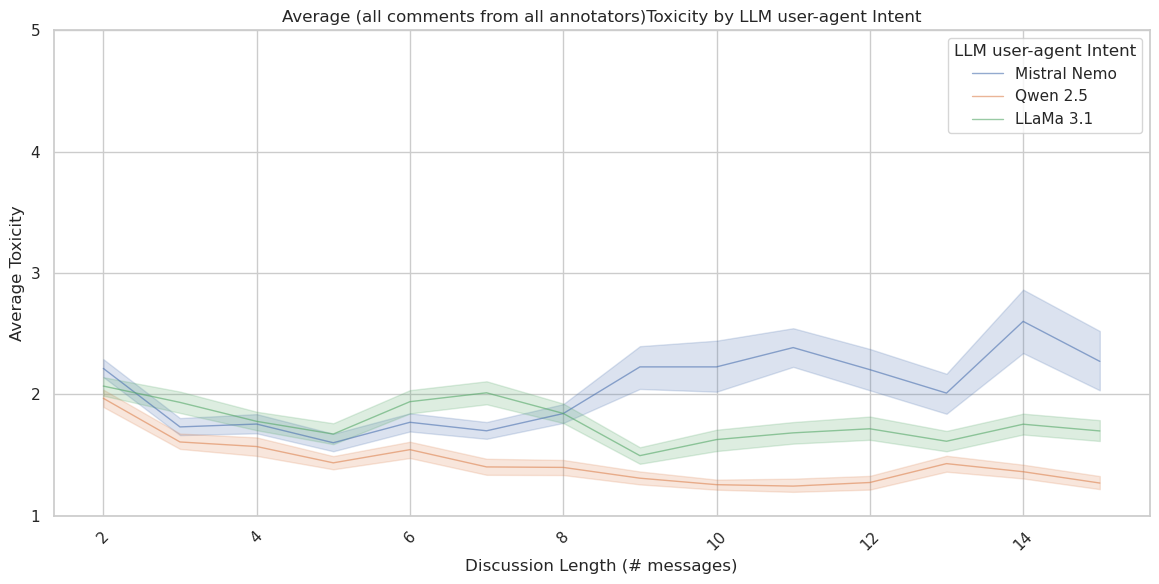

In [11]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Toxicity",
    hue_col="model",
    hue_col_label="LLM user-agent Intent",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

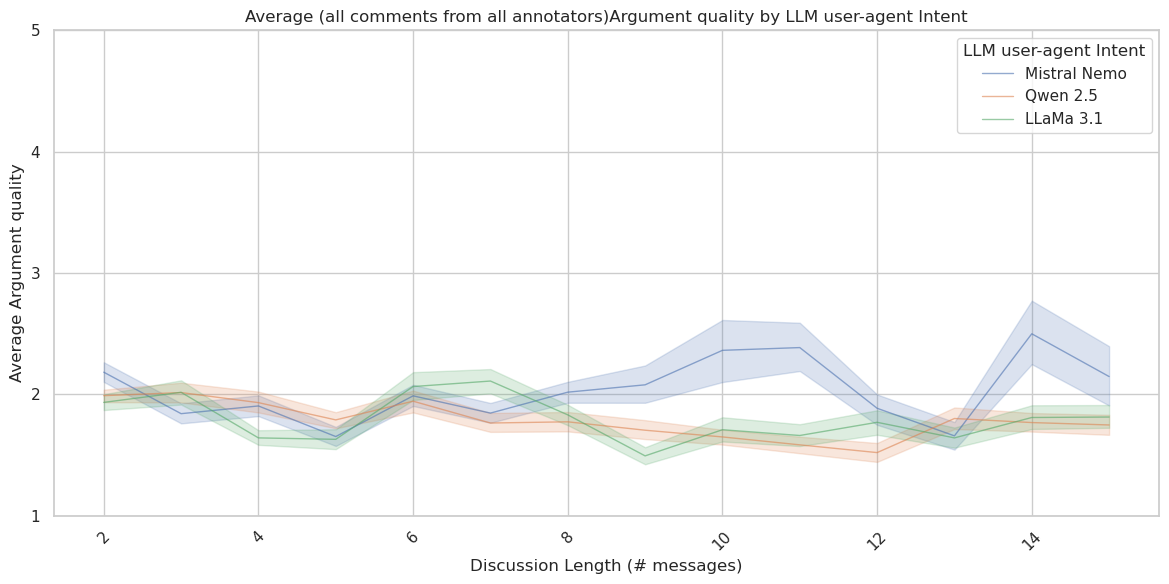

In [12]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Argument Quality",
    hue_col="model",
    hue_col_label="LLM user-agent Intent",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

## Statistics

In [13]:
scipy.stats.spearmanr(no_mod_df['message_order'], no_mod_df['Toxicity'])

SignificanceResult(statistic=-0.156603932377712, pvalue=1.9875559737738855e-101)

In [14]:
model = smf.ols(
    "Toxicity ~ C(conv_variant, Treatment(reference='No Moderator'))*message_order",
    data=no_mod_df
)

# Fit the model
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Toxicity   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     128.7
Date:                Mon, 28 Apr 2025   Prob (F-statistic):          8.13e-286
Time:                        12:43:46   Log-Likelihood:                -23607.
No. Observations:               18414   AIC:                         4.724e+04
Df Residuals:                   18402   BIC:                         4.733e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================================================
                                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                       2.1635      0.034     64.507      0.000       2.098       2.229
C(conv_variant, Treatment(reference='No Moderator'))[T.Human Fac. Guidelines]                  -0.1804      0.049     -3.717      0.000      -0.276      -0.085
C(conv_variant, Treatment(reference='No Moderator'))[T.Human Mod. Guidelines]                  -0.2715      0.048     -5.623      0.000      -0.366      -0.177
C(conv_variant, Treatment(reference='No Moderator'))[T.Moderation Game]                        -0.3322      0.049     -6.718      0.000      -0.429      -0.235
C(conv_variant, Treatment(reference='No Moderator'))[T.No Instructions]                        -0.4046      0.049     -8.276      0.000      -0.500      -0.309
C(conv_variant, Treatment(reference='No Moderator'))[T.Rules Only]                             -0.4240      0.048     -8.780      0.000      -0.519      -0.329
message_order                                                                                  -0.0118      0.004     -3.299      0.001      -0.019      -0.005
C(conv_variant, Treatment(reference='No Moderator'))[T.Human Fac. Guidelines]:message_order    -0.0319      0.005     -5.876      0.000      -0.043      -0.021
C(conv_variant, Treatment(reference='No Moderator'))[T.Human Mod. Guidelines]:message_order    -0.0259      0.005     -4.850      0.000      -0.036      -0.015
C(conv_variant, Treatment(reference='No Moderator'))[T.Moderation Game]:message_order          -0.0345      0.006     -6.260      0.000      -0.045      -0.024
C(conv_variant, Treatment(reference='No Moderator'))[T.No Instructions]:message_order          -0.0089      0.005     -1.617      0.106      -0.020       0.002
C(conv_variant, Treatment(reference='No Moderator'))[T.Rules Only]:message_order               -0.0152      0.005     -2.838      0.005      -0.026      -0.005
==============================================================================
Omnibus:                     2971.792   Durbin-Watson:                   0.316
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4619.206
Skew:                           1.169   Prob(JB):                         0.00
Kurtosis:                       3.746   Cond. No.                         130.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
model = smf.ols(
    "arg_quality ~ C(conv_variant, Treatment(reference='No Moderator'))*message_order",
    data=no_mod_df.rename({"Argument Quality": "arg_quality"}, axis=1),
)

# Fit the model
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            arg_quality   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     33.65
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           7.61e-72
Time:                        12:43:46   Log-Likelihood:                -25548.
No. Observations:               18414   AIC:                         5.112e+04
Df Residuals:                   18402   BIC:                         5.121e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================================================
                                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                       2.1126      0.037     56.689      0.000       2.040       2.186
C(conv_variant, Treatment(reference='No Moderator'))[T.Human Fac. Guidelines]                   0.0109      0.054      0.202      0.840      -0.095       0.117
C(conv_variant, Treatment(reference='No Moderator'))[T.Human Mod. Guidelines]                  -0.1253      0.054     -2.335      0.020      -0.230      -0.020
C(conv_variant, Treatment(reference='No Moderator'))[T.Moderation Game]                        -0.2261      0.055     -4.115      0.000      -0.334      -0.118
C(conv_variant, Treatment(reference='No Moderator'))[T.No Instructions]                        -0.1908      0.054     -3.513      0.000      -0.297      -0.084
C(conv_variant, Treatment(reference='No Moderator'))[T.Rules Only]                             -0.2819      0.054     -5.254      0.000      -0.387      -0.177
message_order                                                                                  -0.0115      0.004     -2.901      0.004      -0.019      -0.004
C(conv_variant, Treatment(reference='No Moderator'))[T.Human Fac. Guidelines]:message_order    -0.0267      0.006     -4.422      0.000      -0.039      -0.015
C(conv_variant, Treatment(reference='No Moderator'))[T.Human Mod. Guidelines]:message_order    -0.0079      0.006     -1.320      0.187      -0.020       0.004
C(conv_variant, Treatment(reference='No Moderator'))[T.Moderation Game]:message_order          -0.0095      0.006     -1.556      0.120      -0.022       0.002
C(conv_variant, Treatment(reference='No Moderator'))[T.No Instructions]:message_order          -0.0009      0.006     -0.151      0.880      -0.013       0.011
C(conv_variant, Treatment(reference='No Moderator'))[T.Rules Only]:message_order               -0.0061      0.006     -1.034      0.301      -0.018       0.006
==============================================================================
Omnibus:                     3686.249   Durbin-Watson:                   0.320
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6472.479
Skew:                           1.305   Prob(JB):                         0.00
Kurtosis:                       4.273   Cond. No.                         130.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Annotator analysis

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/annotator_variance.png


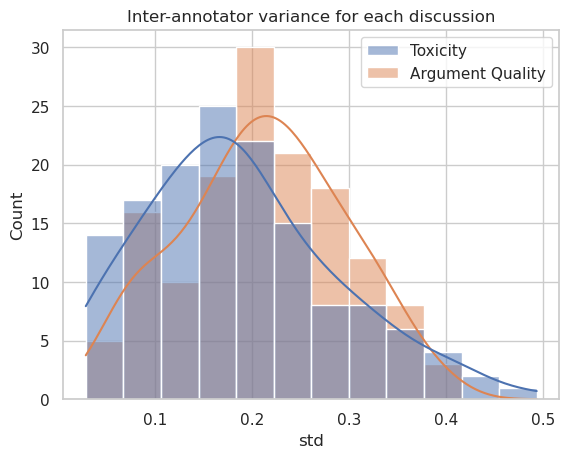

In [16]:
toxicity_var = tasks.stats.discussion_var(
    no_mod_df, "conv_id", "message_id", "Toxicity"
)
argumentq_var = tasks.stats.discussion_var(
    no_mod_df, "conv_id", "message_id", "Argument Quality"
)

sns.histplot([toxicity_var, argumentq_var], kde=True)
plt.title("Inter-annotator variance for each discussion")
plt.xlabel("std")

tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "annotator_variance.png")
plt.show()